# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

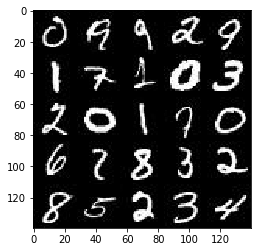

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

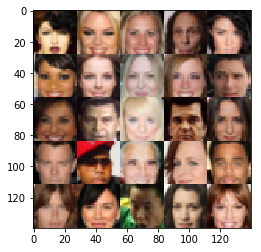

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [116]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    input_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels))
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32, shape=())

    return input_real, input_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [117]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):

        #input is 28x28x1 for MNIST, 28x28x3 for faces
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        # 16x16x64 (?)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [118]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        # 28x28x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [119]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    smooth = 0.1
    real_labels = tf.ones_like(d_model_real) * (1 - smooth)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=real_labels))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [120]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [121]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [132]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model
    
    show_every = 100
    print_every = 10
    
    sample_z = np.random.uniform(-1,1,size=(50,z_dim))
    steps = 0
    
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    g_training_opt, d_training_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            
            # Count number of batches
            number_of_batches = sum(1 for _ in get_batches(batch_size))
            
            for batch_i, batch_images in enumerate(get_batches(batch_size)):
                
                # Train Model
                steps += 1
                batch_images *= 2.0  # saw this on Slack as a tip to get better results, if I don't include it
                                     # the network doesn't get the background as black as it should be
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(g_training_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate: learning_rate})
                #_ = sess.run(g_training_opt, feed_dict={input_z: batch_z}) # Using this invokation instead of the above throws an exception which I don't understand.
                _ = sess.run(d_training_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate: learning_rate})

                if steps % print_every == 0:

                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    progress = 100 * batch_i/number_of_batches
                   
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "{:>6.1f}%".format(progress),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    n_images = 25
                    show_generator_output(sess, n_images, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2...    1.0% Discriminator Loss: 0.4400... Generator Loss: 5.4108
Epoch 1/2...    2.0% Discriminator Loss: 0.5785... Generator Loss: 12.6211
Epoch 1/2...    3.1% Discriminator Loss: 0.3475... Generator Loss: 5.0573
Epoch 1/2...    4.2% Discriminator Loss: 0.3646... Generator Loss: 6.6960
Epoch 1/2...    5.2% Discriminator Loss: 0.3627... Generator Loss: 13.5482
Epoch 1/2...    6.3% Discriminator Loss: 0.4032... Generator Loss: 7.0876
Epoch 1/2...    7.4% Discriminator Loss: 0.3373... Generator Loss: 6.3094
Epoch 1/2...    8.4% Discriminator Loss: 0.3367... Generator Loss: 6.1977
Epoch 1/2...    9.5% Discriminator Loss: 0.3353... Generator Loss: 5.5137
Epoch 1/2...   10.6% Discriminator Loss: 0.3335... Generator Loss: 6.3557


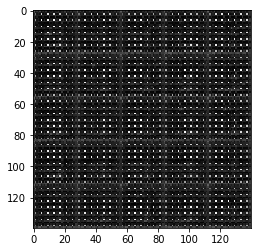

Epoch 1/2...   11.6% Discriminator Loss: 0.3388... Generator Loss: 6.6593
Epoch 1/2...   12.7% Discriminator Loss: 0.3303... Generator Loss: 7.4469
Epoch 1/2...   13.8% Discriminator Loss: 0.3289... Generator Loss: 7.2806
Epoch 1/2...   14.8% Discriminator Loss: 0.3283... Generator Loss: 7.8507
Epoch 1/2...   15.9% Discriminator Loss: 0.3285... Generator Loss: 7.8208
Epoch 1/2...   17.0% Discriminator Loss: 0.3963... Generator Loss: 8.6506
Epoch 1/2...   18.0% Discriminator Loss: 0.3570... Generator Loss: 7.2604
Epoch 1/2...   19.1% Discriminator Loss: 0.3273... Generator Loss: 7.9164
Epoch 1/2...   20.2% Discriminator Loss: 0.3281... Generator Loss: 8.0891
Epoch 1/2...   21.2% Discriminator Loss: 0.3273... Generator Loss: 7.7402


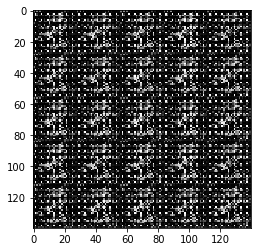

Epoch 1/2...   22.3% Discriminator Loss: 0.3272... Generator Loss: 8.2074
Epoch 1/2...   23.4% Discriminator Loss: 0.3328... Generator Loss: 8.6984
Epoch 1/2...   24.4% Discriminator Loss: 0.3270... Generator Loss: 8.2355
Epoch 1/2...   25.5% Discriminator Loss: 0.3266... Generator Loss: 8.4227
Epoch 1/2...   26.6% Discriminator Loss: 0.3273... Generator Loss: 7.9538
Epoch 1/2...   27.6% Discriminator Loss: 0.3266... Generator Loss: 8.2627
Epoch 1/2...   28.7% Discriminator Loss: 0.3283... Generator Loss: 8.6298
Epoch 1/2...   29.8% Discriminator Loss: 0.3279... Generator Loss: 8.6706
Epoch 1/2...   30.8% Discriminator Loss: 0.3276... Generator Loss: 8.8829
Epoch 1/2...   31.9% Discriminator Loss: 0.3264... Generator Loss: 8.7561


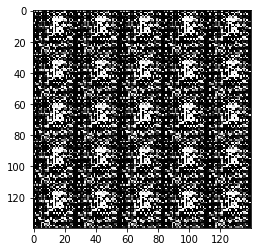

Epoch 1/2...   33.0% Discriminator Loss: 0.3283... Generator Loss: 8.7534
Epoch 1/2...   34.0% Discriminator Loss: 0.3265... Generator Loss: 8.4123
Epoch 1/2...   35.1% Discriminator Loss: 0.3261... Generator Loss: 8.7330
Epoch 1/2...   36.2% Discriminator Loss: 0.3260... Generator Loss: 8.9955
Epoch 1/2...   37.2% Discriminator Loss: 0.3259... Generator Loss: 9.1267
Epoch 1/2...   38.3% Discriminator Loss: 0.3274... Generator Loss: 8.9587
Epoch 1/2...   39.4% Discriminator Loss: 0.3287... Generator Loss: 8.8859
Epoch 1/2...   40.4% Discriminator Loss: 0.3259... Generator Loss: 9.1381
Epoch 1/2...   41.5% Discriminator Loss: 0.3269... Generator Loss: 9.0726
Epoch 1/2...   42.6% Discriminator Loss: 0.3257... Generator Loss: 9.1311


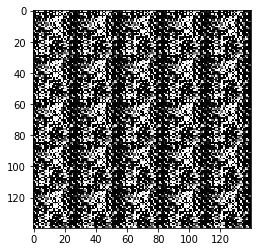

Epoch 1/2...   43.6% Discriminator Loss: 0.3278... Generator Loss: 8.8776
Epoch 1/2...   44.7% Discriminator Loss: 0.3277... Generator Loss: 9.1935
Epoch 1/2...   45.8% Discriminator Loss: 0.3267... Generator Loss: 9.0174
Epoch 1/2...   46.9% Discriminator Loss: 0.3273... Generator Loss: 8.9382
Epoch 1/2...   47.9% Discriminator Loss: 0.3261... Generator Loss: 8.0129
Epoch 1/2...   49.0% Discriminator Loss: 0.3444... Generator Loss: 4.1319
Epoch 1/2...   50.1% Discriminator Loss: 0.5744... Generator Loss: 7.0100
Epoch 1/2...   51.1% Discriminator Loss: 1.1895... Generator Loss: 2.3646
Epoch 1/2...   52.2% Discriminator Loss: 0.7417... Generator Loss: 1.8809
Epoch 1/2...   53.3% Discriminator Loss: 1.0237... Generator Loss: 0.9760


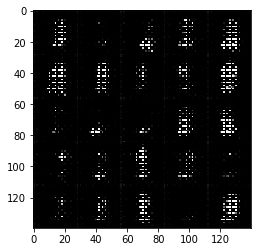

Epoch 1/2...   54.3% Discriminator Loss: 0.5264... Generator Loss: 2.1907
Epoch 1/2...   55.4% Discriminator Loss: 0.7536... Generator Loss: 3.5809
Epoch 1/2...   56.5% Discriminator Loss: 0.8603... Generator Loss: 1.0835
Epoch 1/2...   57.5% Discriminator Loss: 1.1601... Generator Loss: 1.0722
Epoch 1/2...   58.6% Discriminator Loss: 0.7960... Generator Loss: 2.1516
Epoch 1/2...   59.7% Discriminator Loss: 1.0009... Generator Loss: 1.2585
Epoch 1/2...   60.7% Discriminator Loss: 1.0204... Generator Loss: 1.8188
Epoch 1/2...   61.8% Discriminator Loss: 1.2024... Generator Loss: 2.2896
Epoch 1/2...   62.9% Discriminator Loss: 0.7246... Generator Loss: 1.7188
Epoch 1/2...   63.9% Discriminator Loss: 0.8877... Generator Loss: 1.3982


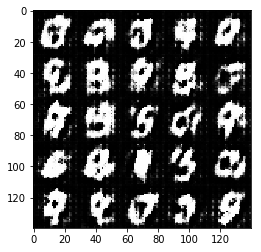

Epoch 1/2...   65.0% Discriminator Loss: 0.8975... Generator Loss: 1.1448
Epoch 1/2...   66.1% Discriminator Loss: 1.0811... Generator Loss: 0.9087
Epoch 1/2...   67.1% Discriminator Loss: 0.9640... Generator Loss: 1.1346
Epoch 1/2...   68.2% Discriminator Loss: 1.1028... Generator Loss: 1.4250
Epoch 1/2...   69.3% Discriminator Loss: 1.1297... Generator Loss: 0.9350
Epoch 1/2...   70.3% Discriminator Loss: 0.9207... Generator Loss: 1.3929
Epoch 1/2...   71.4% Discriminator Loss: 1.0548... Generator Loss: 0.8984
Epoch 1/2...   72.5% Discriminator Loss: 1.7133... Generator Loss: 0.3960
Epoch 1/2...   73.5% Discriminator Loss: 1.0782... Generator Loss: 1.1348
Epoch 1/2...   74.6% Discriminator Loss: 0.8929... Generator Loss: 1.5551


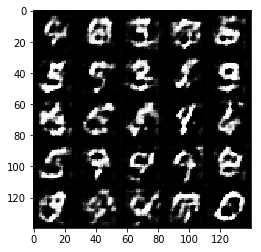

Epoch 1/2...   75.7% Discriminator Loss: 1.0386... Generator Loss: 0.9521
Epoch 1/2...   76.7% Discriminator Loss: 1.6309... Generator Loss: 3.2300
Epoch 1/2...   77.8% Discriminator Loss: 1.2521... Generator Loss: 1.7385
Epoch 1/2...   78.9% Discriminator Loss: 1.1600... Generator Loss: 1.3450
Epoch 1/2...   79.9% Discriminator Loss: 1.3075... Generator Loss: 0.6083
Epoch 1/2...   81.0% Discriminator Loss: 1.1274... Generator Loss: 0.9228
Epoch 1/2...   82.1% Discriminator Loss: 1.1305... Generator Loss: 0.7639
Epoch 1/2...   83.1% Discriminator Loss: 1.4039... Generator Loss: 0.5148
Epoch 1/2...   84.2% Discriminator Loss: 1.0342... Generator Loss: 0.9263
Epoch 1/2...   85.3% Discriminator Loss: 1.2844... Generator Loss: 0.6473


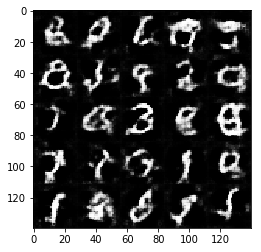

Epoch 1/2...   86.3% Discriminator Loss: 0.9567... Generator Loss: 1.1664
Epoch 1/2...   87.4% Discriminator Loss: 1.3207... Generator Loss: 2.7072
Epoch 1/2...   88.5% Discriminator Loss: 0.9998... Generator Loss: 1.5825
Epoch 1/2...   89.5% Discriminator Loss: 1.4043... Generator Loss: 0.5401
Epoch 1/2...   90.6% Discriminator Loss: 1.0153... Generator Loss: 0.9158
Epoch 1/2...   91.7% Discriminator Loss: 0.9712... Generator Loss: 0.9970
Epoch 1/2...   92.7% Discriminator Loss: 1.2643... Generator Loss: 0.6192
Epoch 1/2...   93.8% Discriminator Loss: 1.1023... Generator Loss: 0.7783
Epoch 1/2...   94.9% Discriminator Loss: 1.9903... Generator Loss: 0.2560
Epoch 1/2...   95.9% Discriminator Loss: 1.1559... Generator Loss: 0.7619


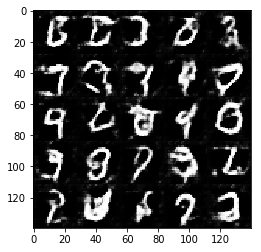

Epoch 1/2...   97.0% Discriminator Loss: 1.1369... Generator Loss: 0.7803
Epoch 1/2...   98.1% Discriminator Loss: 0.8330... Generator Loss: 1.9060
Epoch 1/2...   99.1% Discriminator Loss: 0.8563... Generator Loss: 1.2023
Epoch 2/2...    0.2% Discriminator Loss: 0.9573... Generator Loss: 1.4335
Epoch 2/2...    1.3% Discriminator Loss: 0.9617... Generator Loss: 1.3145
Epoch 2/2...    2.3% Discriminator Loss: 0.9145... Generator Loss: 1.1591
Epoch 2/2...    3.4% Discriminator Loss: 0.7890... Generator Loss: 1.4454
Epoch 2/2...    4.5% Discriminator Loss: 0.9246... Generator Loss: 1.1963
Epoch 2/2...    5.5% Discriminator Loss: 0.8604... Generator Loss: 1.2614
Epoch 2/2...    6.6% Discriminator Loss: 1.5209... Generator Loss: 0.5051


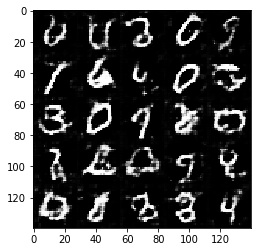

Epoch 2/2...    7.7% Discriminator Loss: 0.9931... Generator Loss: 1.0307
Epoch 2/2...    8.8% Discriminator Loss: 0.9461... Generator Loss: 1.1276
Epoch 2/2...    9.8% Discriminator Loss: 1.0425... Generator Loss: 0.9584
Epoch 2/2...   10.9% Discriminator Loss: 1.2689... Generator Loss: 0.5686
Epoch 2/2...   12.0% Discriminator Loss: 0.8487... Generator Loss: 1.2101
Epoch 2/2...   13.0% Discriminator Loss: 0.9020... Generator Loss: 1.1790
Epoch 2/2...   14.1% Discriminator Loss: 0.9927... Generator Loss: 1.4067
Epoch 2/2...   15.2% Discriminator Loss: 0.9524... Generator Loss: 1.0236
Epoch 2/2...   16.2% Discriminator Loss: 0.9113... Generator Loss: 1.6352
Epoch 2/2...   17.3% Discriminator Loss: 1.2721... Generator Loss: 0.6182


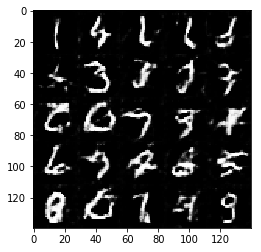

Epoch 2/2...   18.4% Discriminator Loss: 0.8992... Generator Loss: 1.2622
Epoch 2/2...   19.4% Discriminator Loss: 1.2571... Generator Loss: 0.6347
Epoch 2/2...   20.5% Discriminator Loss: 0.8677... Generator Loss: 1.4524
Epoch 2/2...   21.6% Discriminator Loss: 0.9639... Generator Loss: 1.2965
Epoch 2/2...   22.6% Discriminator Loss: 0.9392... Generator Loss: 1.0636
Epoch 2/2...   23.7% Discriminator Loss: 1.2224... Generator Loss: 0.6448
Epoch 2/2...   24.8% Discriminator Loss: 2.9302... Generator Loss: 4.4175
Epoch 2/2...   25.8% Discriminator Loss: 1.0646... Generator Loss: 0.8699
Epoch 2/2...   26.9% Discriminator Loss: 1.0671... Generator Loss: 0.8551
Epoch 2/2...   28.0% Discriminator Loss: 0.9136... Generator Loss: 1.1381


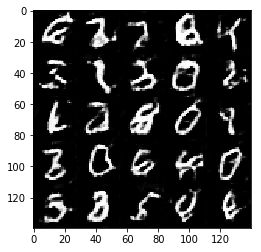

Epoch 2/2...   29.0% Discriminator Loss: 1.1347... Generator Loss: 0.7211
Epoch 2/2...   30.1% Discriminator Loss: 0.8874... Generator Loss: 1.0855
Epoch 2/2...   31.2% Discriminator Loss: 1.0804... Generator Loss: 0.8008
Epoch 2/2...   32.2% Discriminator Loss: 0.9457... Generator Loss: 1.1444
Epoch 2/2...   33.3% Discriminator Loss: 1.1271... Generator Loss: 0.7476
Epoch 2/2...   34.4% Discriminator Loss: 0.9515... Generator Loss: 1.5716
Epoch 2/2...   35.4% Discriminator Loss: 1.1649... Generator Loss: 0.7428
Epoch 2/2...   36.5% Discriminator Loss: 1.0714... Generator Loss: 0.9850
Epoch 2/2...   37.6% Discriminator Loss: 1.1043... Generator Loss: 0.7504
Epoch 2/2...   38.6% Discriminator Loss: 0.8542... Generator Loss: 1.8483


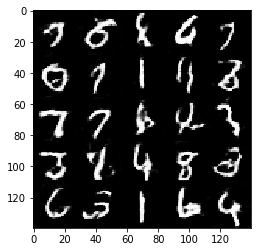

Epoch 2/2...   39.7% Discriminator Loss: 1.3405... Generator Loss: 0.5872
Epoch 2/2...   40.8% Discriminator Loss: 1.0315... Generator Loss: 1.1464
Epoch 2/2...   41.8% Discriminator Loss: 1.3421... Generator Loss: 0.5770
Epoch 2/2...   42.9% Discriminator Loss: 1.0394... Generator Loss: 0.8887
Epoch 2/2...   44.0% Discriminator Loss: 1.0882... Generator Loss: 2.6388
Epoch 2/2...   45.0% Discriminator Loss: 1.0774... Generator Loss: 1.1441
Epoch 2/2...   46.1% Discriminator Loss: 0.9065... Generator Loss: 1.1990
Epoch 2/2...   47.2% Discriminator Loss: 1.5049... Generator Loss: 0.4951
Epoch 2/2...   48.2% Discriminator Loss: 1.0104... Generator Loss: 1.1892
Epoch 2/2...   49.3% Discriminator Loss: 1.2914... Generator Loss: 2.8052


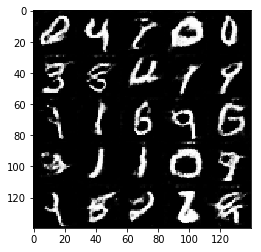

Epoch 2/2...   50.4% Discriminator Loss: 1.1036... Generator Loss: 0.7894
Epoch 2/2...   51.4% Discriminator Loss: 1.0381... Generator Loss: 1.5944
Epoch 2/2...   52.5% Discriminator Loss: 1.4669... Generator Loss: 0.4703
Epoch 2/2...   53.6% Discriminator Loss: 1.1090... Generator Loss: 1.8014
Epoch 2/2...   54.6% Discriminator Loss: 1.3422... Generator Loss: 0.5657
Epoch 2/2...   55.7% Discriminator Loss: 0.9591... Generator Loss: 0.9848
Epoch 2/2...   56.8% Discriminator Loss: 1.5988... Generator Loss: 3.1649
Epoch 2/2...   57.8% Discriminator Loss: 1.0429... Generator Loss: 1.0930
Epoch 2/2...   58.9% Discriminator Loss: 1.0067... Generator Loss: 1.2774
Epoch 2/2...   60.0% Discriminator Loss: 0.9323... Generator Loss: 1.3223


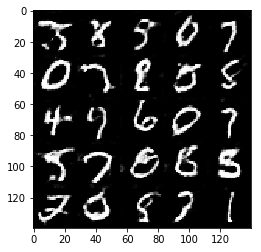

Epoch 2/2...   61.0% Discriminator Loss: 1.5833... Generator Loss: 0.5007
Epoch 2/2...   62.1% Discriminator Loss: 0.9567... Generator Loss: 1.2006
Epoch 2/2...   63.2% Discriminator Loss: 0.8912... Generator Loss: 1.1557
Epoch 2/2...   64.2% Discriminator Loss: 0.9830... Generator Loss: 1.0235
Epoch 2/2...   65.3% Discriminator Loss: 1.3061... Generator Loss: 0.5984
Epoch 2/2...   66.4% Discriminator Loss: 1.1047... Generator Loss: 0.8565
Epoch 2/2...   67.4% Discriminator Loss: 1.0305... Generator Loss: 1.0388
Epoch 2/2...   68.5% Discriminator Loss: 1.0279... Generator Loss: 0.9949
Epoch 2/2...   69.6% Discriminator Loss: 1.1946... Generator Loss: 0.6480
Epoch 2/2...   70.7% Discriminator Loss: 1.0903... Generator Loss: 0.8064


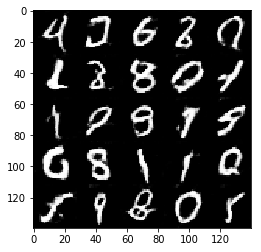

Epoch 2/2...   71.7% Discriminator Loss: 1.6033... Generator Loss: 0.5285
Epoch 2/2...   72.8% Discriminator Loss: 1.0728... Generator Loss: 0.8695
Epoch 2/2...   73.9% Discriminator Loss: 1.1567... Generator Loss: 2.2588
Epoch 2/2...   74.9% Discriminator Loss: 1.0073... Generator Loss: 1.0127
Epoch 2/2...   76.0% Discriminator Loss: 1.0114... Generator Loss: 0.9925
Epoch 2/2...   77.1% Discriminator Loss: 0.9321... Generator Loss: 2.0104
Epoch 2/2...   78.1% Discriminator Loss: 1.0593... Generator Loss: 1.2373
Epoch 2/2...   79.2% Discriminator Loss: 0.9094... Generator Loss: 1.5866
Epoch 2/2...   80.3% Discriminator Loss: 0.9120... Generator Loss: 1.4132
Epoch 2/2...   81.3% Discriminator Loss: 1.1777... Generator Loss: 0.7100


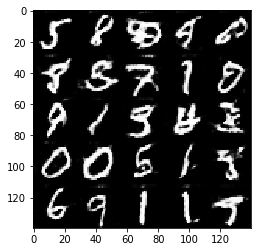

Epoch 2/2...   82.4% Discriminator Loss: 0.8249... Generator Loss: 1.5570
Epoch 2/2...   83.5% Discriminator Loss: 0.9436... Generator Loss: 0.9895
Epoch 2/2...   84.5% Discriminator Loss: 1.1736... Generator Loss: 0.7312
Epoch 2/2...   85.6% Discriminator Loss: 1.1273... Generator Loss: 0.8379
Epoch 2/2...   86.7% Discriminator Loss: 0.8225... Generator Loss: 1.7783
Epoch 2/2...   87.7% Discriminator Loss: 1.1259... Generator Loss: 1.1421
Epoch 2/2...   88.8% Discriminator Loss: 0.8712... Generator Loss: 1.5945
Epoch 2/2...   89.9% Discriminator Loss: 0.7867... Generator Loss: 1.5232
Epoch 2/2...   90.9% Discriminator Loss: 1.1119... Generator Loss: 0.8019
Epoch 2/2...   92.0% Discriminator Loss: 1.3463... Generator Loss: 0.6250


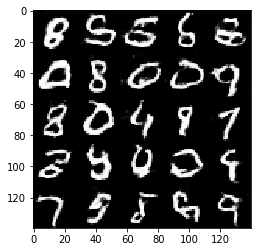

Epoch 2/2...   93.1% Discriminator Loss: 1.2800... Generator Loss: 0.6475
Epoch 2/2...   94.1% Discriminator Loss: 1.5661... Generator Loss: 0.5268
Epoch 2/2...   95.2% Discriminator Loss: 0.9163... Generator Loss: 1.0363
Epoch 2/2...   96.3% Discriminator Loss: 0.8196... Generator Loss: 1.6151
Epoch 2/2...   97.3% Discriminator Loss: 1.1484... Generator Loss: 0.8886
Epoch 2/2...   98.4% Discriminator Loss: 0.9201... Generator Loss: 1.7383
Epoch 2/2...   99.5% Discriminator Loss: 0.8893... Generator Loss: 1.5095


In [133]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1...    0.1% Discriminator Loss: 0.7655... Generator Loss: 1.3503
Epoch 1/1...    0.3% Discriminator Loss: 0.6190... Generator Loss: 1.6489
Epoch 1/1...    0.5% Discriminator Loss: 0.7500... Generator Loss: 1.2039
Epoch 1/1...    0.6% Discriminator Loss: 0.4705... Generator Loss: 2.5120
Epoch 1/1...    0.8% Discriminator Loss: 0.4224... Generator Loss: 2.7931
Epoch 1/1...    0.9% Discriminator Loss: 0.3973... Generator Loss: 3.1759
Epoch 1/1...    1.1% Discriminator Loss: 0.4649... Generator Loss: 2.8940
Epoch 1/1...    1.2% Discriminator Loss: 0.4673... Generator Loss: 3.2615
Epoch 1/1...    1.4% Discriminator Loss: 0.4164... Generator Loss: 3.5419
Epoch 1/1...    1.6% Discriminator Loss: 0.3683... Generator Loss: 6.3590


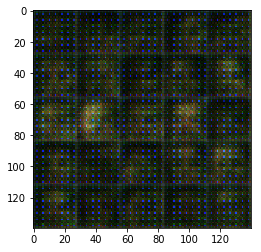

Epoch 1/1...    1.7% Discriminator Loss: 0.3625... Generator Loss: 4.5028
Epoch 1/1...    1.9% Discriminator Loss: 0.3629... Generator Loss: 5.2021
Epoch 1/1...    2.0% Discriminator Loss: 0.3483... Generator Loss: 4.8017
Epoch 1/1...    2.2% Discriminator Loss: 0.4786... Generator Loss: 6.7982
Epoch 1/1...    2.4% Discriminator Loss: 0.8659... Generator Loss: 10.8868
Epoch 1/1...    2.5% Discriminator Loss: 0.4326... Generator Loss: 3.2301
Epoch 1/1...    2.7% Discriminator Loss: 0.3604... Generator Loss: 5.2261
Epoch 1/1...    2.8% Discriminator Loss: 0.3752... Generator Loss: 4.0687
Epoch 1/1...    3.0% Discriminator Loss: 0.3771... Generator Loss: 3.9032
Epoch 1/1...    3.1% Discriminator Loss: 0.3467... Generator Loss: 5.7888


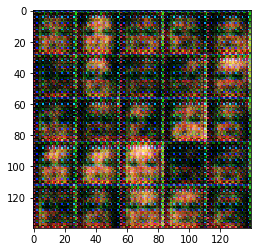

Epoch 1/1...    3.3% Discriminator Loss: 0.3367... Generator Loss: 5.6205
Epoch 1/1...    3.5% Discriminator Loss: 0.3378... Generator Loss: 5.2107
Epoch 1/1...    3.6% Discriminator Loss: 0.4490... Generator Loss: 2.4992
Epoch 1/1...    3.8% Discriminator Loss: 0.3642... Generator Loss: 4.5465
Epoch 1/1...    3.9% Discriminator Loss: 1.2345... Generator Loss: 0.9257
Epoch 1/1...    4.1% Discriminator Loss: 0.9631... Generator Loss: 1.0514
Epoch 1/1...    4.2% Discriminator Loss: 0.8170... Generator Loss: 1.5197
Epoch 1/1...    4.4% Discriminator Loss: 0.5336... Generator Loss: 2.5545
Epoch 1/1...    4.6% Discriminator Loss: 1.0667... Generator Loss: 0.8518
Epoch 1/1...    4.7% Discriminator Loss: 0.7573... Generator Loss: 1.9151


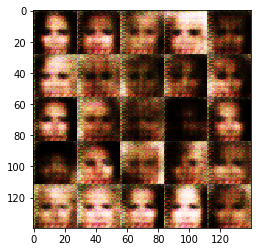

Epoch 1/1...    4.9% Discriminator Loss: 0.7872... Generator Loss: 1.2290
Epoch 1/1...    5.0% Discriminator Loss: 0.8475... Generator Loss: 1.2754
Epoch 1/1...    5.2% Discriminator Loss: 0.5906... Generator Loss: 1.7557
Epoch 1/1...    5.4% Discriminator Loss: 0.4172... Generator Loss: 3.8079
Epoch 1/1...    5.5% Discriminator Loss: 0.5448... Generator Loss: 1.8616
Epoch 1/1...    5.7% Discriminator Loss: 0.5795... Generator Loss: 1.8517
Epoch 1/1...    5.8% Discriminator Loss: 0.5477... Generator Loss: 3.7708
Epoch 1/1...    6.0% Discriminator Loss: 0.5614... Generator Loss: 2.8999
Epoch 1/1...    6.1% Discriminator Loss: 0.7569... Generator Loss: 4.2003
Epoch 1/1...    6.3% Discriminator Loss: 0.7860... Generator Loss: 1.8117


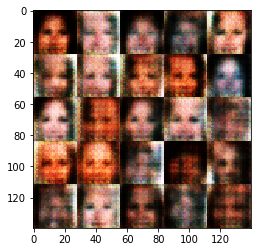

Epoch 1/1...    6.5% Discriminator Loss: 0.6369... Generator Loss: 1.6743
Epoch 1/1...    6.6% Discriminator Loss: 1.4251... Generator Loss: 0.4870
Epoch 1/1...    6.8% Discriminator Loss: 1.0160... Generator Loss: 0.8287
Epoch 1/1...    6.9% Discriminator Loss: 1.4000... Generator Loss: 0.6214
Epoch 1/1...    7.1% Discriminator Loss: 0.9271... Generator Loss: 1.1958
Epoch 1/1...    7.3% Discriminator Loss: 0.6451... Generator Loss: 1.7599
Epoch 1/1...    7.4% Discriminator Loss: 0.4309... Generator Loss: 3.7280
Epoch 1/1...    7.6% Discriminator Loss: 1.4567... Generator Loss: 0.4743
Epoch 1/1...    7.7% Discriminator Loss: 0.4602... Generator Loss: 3.1339
Epoch 1/1...    7.9% Discriminator Loss: 1.1426... Generator Loss: 3.2706


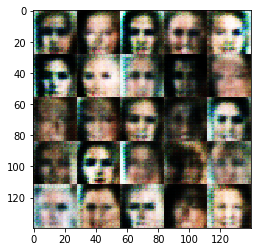

Epoch 1/1...    8.0% Discriminator Loss: 0.7342... Generator Loss: 2.0490
Epoch 1/1...    8.2% Discriminator Loss: 0.6796... Generator Loss: 1.6576
Epoch 1/1...    8.4% Discriminator Loss: 1.0380... Generator Loss: 1.0198
Epoch 1/1...    8.5% Discriminator Loss: 0.6169... Generator Loss: 3.3931
Epoch 1/1...    8.7% Discriminator Loss: 0.8477... Generator Loss: 1.2509
Epoch 1/1...    8.8% Discriminator Loss: 0.7041... Generator Loss: 1.4148
Epoch 1/1...    9.0% Discriminator Loss: 0.5081... Generator Loss: 2.6783
Epoch 1/1...    9.1% Discriminator Loss: 0.4988... Generator Loss: 3.0123
Epoch 1/1...    9.3% Discriminator Loss: 0.6977... Generator Loss: 1.6654
Epoch 1/1...    9.5% Discriminator Loss: 1.3896... Generator Loss: 0.5181


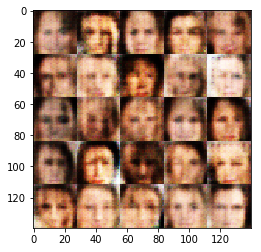

Epoch 1/1...    9.6% Discriminator Loss: 0.9355... Generator Loss: 1.0923
Epoch 1/1...    9.8% Discriminator Loss: 0.7413... Generator Loss: 1.4443
Epoch 1/1...    9.9% Discriminator Loss: 1.0073... Generator Loss: 1.0224
Epoch 1/1...   10.1% Discriminator Loss: 0.8084... Generator Loss: 1.2903
Epoch 1/1...   10.3% Discriminator Loss: 0.6905... Generator Loss: 2.0989
Epoch 1/1...   10.4% Discriminator Loss: 1.0106... Generator Loss: 0.9952
Epoch 1/1...   10.6% Discriminator Loss: 0.8221... Generator Loss: 1.2449
Epoch 1/1...   10.7% Discriminator Loss: 1.2231... Generator Loss: 0.6407
Epoch 1/1...   10.9% Discriminator Loss: 0.8245... Generator Loss: 1.2124
Epoch 1/1...   11.0% Discriminator Loss: 0.4608... Generator Loss: 2.7844


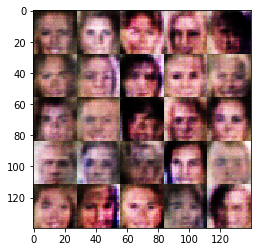

Epoch 1/1...   11.2% Discriminator Loss: 0.4451... Generator Loss: 4.7256
Epoch 1/1...   11.4% Discriminator Loss: 0.6265... Generator Loss: 1.6113
Epoch 1/1...   11.5% Discriminator Loss: 0.9742... Generator Loss: 1.5202
Epoch 1/1...   11.7% Discriminator Loss: 1.4588... Generator Loss: 0.5274
Epoch 1/1...   11.8% Discriminator Loss: 0.5776... Generator Loss: 2.2861
Epoch 1/1...   12.0% Discriminator Loss: 0.7516... Generator Loss: 1.3297
Epoch 1/1...   12.1% Discriminator Loss: 0.6640... Generator Loss: 2.4526
Epoch 1/1...   12.3% Discriminator Loss: 0.8908... Generator Loss: 1.4249
Epoch 1/1...   12.5% Discriminator Loss: 1.7265... Generator Loss: 0.3649
Epoch 1/1...   12.6% Discriminator Loss: 1.1450... Generator Loss: 0.9428


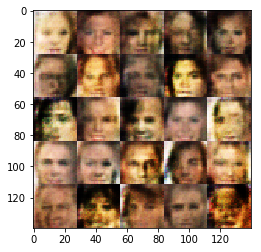

Epoch 1/1...   12.8% Discriminator Loss: 0.8726... Generator Loss: 1.2526
Epoch 1/1...   12.9% Discriminator Loss: 0.8800... Generator Loss: 1.2525
Epoch 1/1...   13.1% Discriminator Loss: 0.8365... Generator Loss: 1.2992
Epoch 1/1...   13.3% Discriminator Loss: 0.9708... Generator Loss: 1.2926
Epoch 1/1...   13.4% Discriminator Loss: 1.2847... Generator Loss: 0.6085
Epoch 1/1...   13.6% Discriminator Loss: 0.6926... Generator Loss: 1.6201
Epoch 1/1...   13.7% Discriminator Loss: 0.5920... Generator Loss: 1.8906
Epoch 1/1...   13.9% Discriminator Loss: 1.5180... Generator Loss: 7.4623
Epoch 1/1...   14.0% Discriminator Loss: 0.4849... Generator Loss: 4.9762
Epoch 1/1...   14.2% Discriminator Loss: 1.4307... Generator Loss: 6.6170


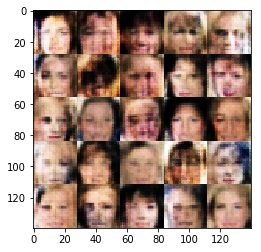

Epoch 1/1...   14.4% Discriminator Loss: 1.7331... Generator Loss: 0.3342
Epoch 1/1...   14.5% Discriminator Loss: 0.6194... Generator Loss: 2.7095
Epoch 1/1...   14.7% Discriminator Loss: 0.8663... Generator Loss: 1.0785
Epoch 1/1...   14.8% Discriminator Loss: 0.9817... Generator Loss: 0.9817
Epoch 1/1...   15.0% Discriminator Loss: 0.6645... Generator Loss: 2.4970
Epoch 1/1...   15.1% Discriminator Loss: 1.3805... Generator Loss: 0.5262
Epoch 1/1...   15.3% Discriminator Loss: 0.8668... Generator Loss: 1.6458
Epoch 1/1...   15.5% Discriminator Loss: 0.7044... Generator Loss: 1.3958
Epoch 1/1...   15.6% Discriminator Loss: 0.6493... Generator Loss: 1.8663
Epoch 1/1...   15.8% Discriminator Loss: 0.6923... Generator Loss: 1.5727


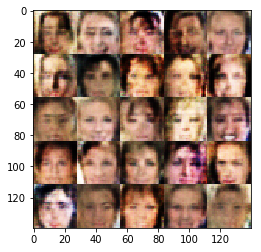

Epoch 1/1...   15.9% Discriminator Loss: 1.1864... Generator Loss: 0.6849
Epoch 1/1...   16.1% Discriminator Loss: 0.5459... Generator Loss: 3.2079
Epoch 1/1...   16.3% Discriminator Loss: 0.6286... Generator Loss: 1.7175
Epoch 1/1...   16.4% Discriminator Loss: 1.7351... Generator Loss: 4.4056
Epoch 1/1...   16.6% Discriminator Loss: 0.4948... Generator Loss: 2.5161
Epoch 1/1...   16.7% Discriminator Loss: 0.5693... Generator Loss: 2.1035
Epoch 1/1...   16.9% Discriminator Loss: 0.8355... Generator Loss: 1.1801
Epoch 1/1...   17.0% Discriminator Loss: 0.5149... Generator Loss: 1.9951
Epoch 1/1...   17.2% Discriminator Loss: 0.4671... Generator Loss: 2.2792
Epoch 1/1...   17.4% Discriminator Loss: 0.6717... Generator Loss: 1.4609


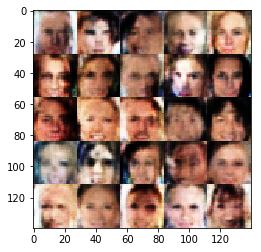

Epoch 1/1...   17.5% Discriminator Loss: 1.5266... Generator Loss: 3.5439
Epoch 1/1...   17.7% Discriminator Loss: 0.8735... Generator Loss: 1.0429
Epoch 1/1...   17.8% Discriminator Loss: 1.1889... Generator Loss: 0.7260
Epoch 1/1...   18.0% Discriminator Loss: 0.6651... Generator Loss: 1.5165
Epoch 1/1...   18.1% Discriminator Loss: 1.0074... Generator Loss: 0.7999
Epoch 1/1...   18.3% Discriminator Loss: 0.4779... Generator Loss: 3.6481
Epoch 1/1...   18.5% Discriminator Loss: 0.5402... Generator Loss: 1.8943
Epoch 1/1...   18.6% Discriminator Loss: 0.7805... Generator Loss: 1.4146
Epoch 1/1...   18.8% Discriminator Loss: 0.9376... Generator Loss: 2.6306
Epoch 1/1...   18.9% Discriminator Loss: 1.5421... Generator Loss: 0.4132


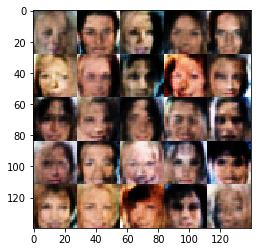

Epoch 1/1...   19.1% Discriminator Loss: 0.5096... Generator Loss: 2.0235
Epoch 1/1...   19.3% Discriminator Loss: 0.3665... Generator Loss: 4.1756
Epoch 1/1...   19.4% Discriminator Loss: 0.5679... Generator Loss: 2.4293
Epoch 1/1...   19.6% Discriminator Loss: 0.8196... Generator Loss: 1.1906
Epoch 1/1...   19.7% Discriminator Loss: 1.6237... Generator Loss: 1.0246
Epoch 1/1...   19.9% Discriminator Loss: 0.6448... Generator Loss: 1.7232
Epoch 1/1...   20.0% Discriminator Loss: 0.7157... Generator Loss: 1.4689
Epoch 1/1...   20.2% Discriminator Loss: 0.6665... Generator Loss: 1.4675
Epoch 1/1...   20.4% Discriminator Loss: 0.6286... Generator Loss: 1.8797
Epoch 1/1...   20.5% Discriminator Loss: 0.8121... Generator Loss: 1.1870


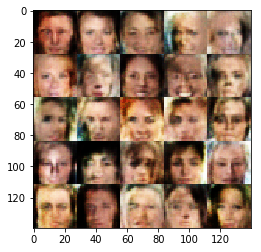

Epoch 1/1...   20.7% Discriminator Loss: 0.8123... Generator Loss: 1.1674
Epoch 1/1...   20.8% Discriminator Loss: 0.4534... Generator Loss: 2.4547
Epoch 1/1...   21.0% Discriminator Loss: 0.4715... Generator Loss: 2.2627
Epoch 1/1...   21.1% Discriminator Loss: 0.3968... Generator Loss: 3.7871
Epoch 1/1...   21.3% Discriminator Loss: 0.4440... Generator Loss: 2.7655
Epoch 1/1...   21.5% Discriminator Loss: 1.2113... Generator Loss: 0.6658
Epoch 1/1...   21.6% Discriminator Loss: 0.4958... Generator Loss: 2.1377
Epoch 1/1...   21.8% Discriminator Loss: 0.7797... Generator Loss: 1.7977
Epoch 1/1...   21.9% Discriminator Loss: 0.6451... Generator Loss: 2.8597
Epoch 1/1...   22.1% Discriminator Loss: 0.6798... Generator Loss: 2.9399


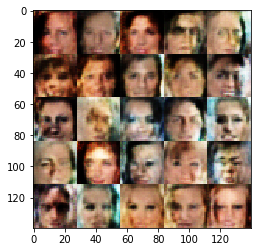

Epoch 1/1...   22.3% Discriminator Loss: 1.0682... Generator Loss: 1.4086
Epoch 1/1...   22.4% Discriminator Loss: 0.7676... Generator Loss: 1.3317
Epoch 1/1...   22.6% Discriminator Loss: 0.4491... Generator Loss: 2.5674
Epoch 1/1...   22.7% Discriminator Loss: 0.8832... Generator Loss: 1.0696
Epoch 1/1...   22.9% Discriminator Loss: 0.8383... Generator Loss: 1.0423
Epoch 1/1...   23.0% Discriminator Loss: 2.2872... Generator Loss: 0.1954
Epoch 1/1...   23.2% Discriminator Loss: 0.8386... Generator Loss: 1.0932
Epoch 1/1...   23.4% Discriminator Loss: 1.3576... Generator Loss: 0.5812
Epoch 1/1...   23.5% Discriminator Loss: 1.2879... Generator Loss: 0.5859
Epoch 1/1...   23.7% Discriminator Loss: 0.4279... Generator Loss: 2.6860


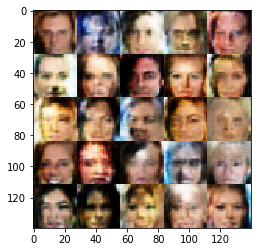

Epoch 1/1...   23.8% Discriminator Loss: 0.5096... Generator Loss: 2.2593
Epoch 1/1...   24.0% Discriminator Loss: 0.5209... Generator Loss: 2.1824
Epoch 1/1...   24.2% Discriminator Loss: 0.9329... Generator Loss: 0.9085
Epoch 1/1...   24.3% Discriminator Loss: 0.7363... Generator Loss: 2.0227
Epoch 1/1...   24.5% Discriminator Loss: 0.8904... Generator Loss: 1.1637
Epoch 1/1...   24.6% Discriminator Loss: 0.4571... Generator Loss: 2.6897
Epoch 1/1...   24.8% Discriminator Loss: 0.5233... Generator Loss: 2.2795
Epoch 1/1...   24.9% Discriminator Loss: 0.6097... Generator Loss: 2.3867
Epoch 1/1...   25.1% Discriminator Loss: 0.6942... Generator Loss: 2.5026
Epoch 1/1...   25.3% Discriminator Loss: 1.3989... Generator Loss: 0.5434


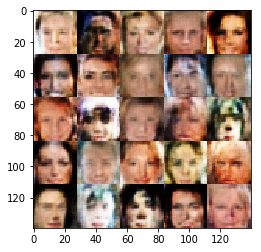

Epoch 1/1...   25.4% Discriminator Loss: 0.7035... Generator Loss: 1.3170
Epoch 1/1...   25.6% Discriminator Loss: 0.7045... Generator Loss: 1.3138
Epoch 1/1...   25.7% Discriminator Loss: 1.1969... Generator Loss: 0.6758
Epoch 1/1...   25.9% Discriminator Loss: 0.7957... Generator Loss: 1.1710
Epoch 1/1...   26.0% Discriminator Loss: 1.2689... Generator Loss: 0.5781
Epoch 1/1...   26.2% Discriminator Loss: 0.4201... Generator Loss: 4.1189
Epoch 1/1...   26.4% Discriminator Loss: 0.4737... Generator Loss: 2.2355
Epoch 1/1...   26.5% Discriminator Loss: 0.3752... Generator Loss: 4.4498
Epoch 1/1...   26.7% Discriminator Loss: 1.0804... Generator Loss: 0.7539
Epoch 1/1...   26.8% Discriminator Loss: 0.7221... Generator Loss: 1.2988


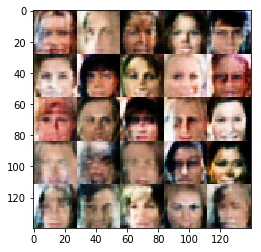

Epoch 1/1...   27.0% Discriminator Loss: 0.4590... Generator Loss: 2.5026
Epoch 1/1...   27.2% Discriminator Loss: 1.0330... Generator Loss: 4.4032
Epoch 1/1...   27.3% Discriminator Loss: 0.6760... Generator Loss: 1.4569
Epoch 1/1...   27.5% Discriminator Loss: 1.1313... Generator Loss: 0.7954
Epoch 1/1...   27.6% Discriminator Loss: 0.4694... Generator Loss: 2.9835
Epoch 1/1...   27.8% Discriminator Loss: 0.9101... Generator Loss: 0.9219
Epoch 1/1...   27.9% Discriminator Loss: 0.6265... Generator Loss: 2.8728
Epoch 1/1...   28.1% Discriminator Loss: 0.7175... Generator Loss: 5.3961
Epoch 1/1...   28.3% Discriminator Loss: 1.7212... Generator Loss: 0.3273
Epoch 1/1...   28.4% Discriminator Loss: 1.2413... Generator Loss: 0.5853


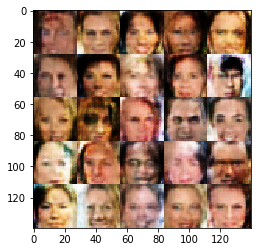

Epoch 1/1...   28.6% Discriminator Loss: 0.4138... Generator Loss: 3.6356
Epoch 1/1...   28.7% Discriminator Loss: 0.4867... Generator Loss: 2.3092
Epoch 1/1...   28.9% Discriminator Loss: 0.8586... Generator Loss: 2.1406
Epoch 1/1...   29.0% Discriminator Loss: 1.0681... Generator Loss: 1.1358
Epoch 1/1...   29.2% Discriminator Loss: 1.1918... Generator Loss: 0.6836
Epoch 1/1...   29.4% Discriminator Loss: 0.6689... Generator Loss: 2.1339
Epoch 1/1...   29.5% Discriminator Loss: 0.4835... Generator Loss: 2.3131
Epoch 1/1...   29.7% Discriminator Loss: 0.8140... Generator Loss: 1.0731
Epoch 1/1...   29.8% Discriminator Loss: 0.8392... Generator Loss: 1.3574
Epoch 1/1...   30.0% Discriminator Loss: 0.9776... Generator Loss: 0.8396


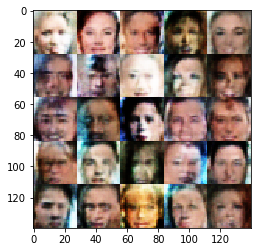

Epoch 1/1...   30.2% Discriminator Loss: 1.0951... Generator Loss: 0.7716
Epoch 1/1...   30.3% Discriminator Loss: 0.5852... Generator Loss: 1.9896
Epoch 1/1...   30.5% Discriminator Loss: 1.1797... Generator Loss: 0.6616
Epoch 1/1...   30.6% Discriminator Loss: 0.7114... Generator Loss: 2.1917
Epoch 1/1...   30.8% Discriminator Loss: 1.1179... Generator Loss: 0.6896
Epoch 1/1...   30.9% Discriminator Loss: 0.5175... Generator Loss: 3.2786
Epoch 1/1...   31.1% Discriminator Loss: 1.5203... Generator Loss: 0.4878
Epoch 1/1...   31.3% Discriminator Loss: 0.4188... Generator Loss: 2.9861
Epoch 1/1...   31.4% Discriminator Loss: 0.4778... Generator Loss: 2.5568
Epoch 1/1...   31.6% Discriminator Loss: 0.5074... Generator Loss: 2.0087


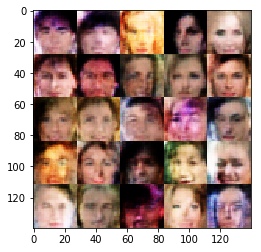

Epoch 1/1...   31.7% Discriminator Loss: 0.5931... Generator Loss: 1.8282
Epoch 1/1...   31.9% Discriminator Loss: 0.6562... Generator Loss: 1.4012
Epoch 1/1...   32.0% Discriminator Loss: 0.4130... Generator Loss: 2.9901
Epoch 1/1...   32.2% Discriminator Loss: 1.2205... Generator Loss: 0.7523
Epoch 1/1...   32.4% Discriminator Loss: 0.7261... Generator Loss: 1.6781
Epoch 1/1...   32.5% Discriminator Loss: 2.0201... Generator Loss: 0.2659
Epoch 1/1...   32.7% Discriminator Loss: 0.8723... Generator Loss: 1.0629
Epoch 1/1...   32.8% Discriminator Loss: 0.4518... Generator Loss: 3.1142
Epoch 1/1...   33.0% Discriminator Loss: 1.2443... Generator Loss: 0.5975
Epoch 1/1...   33.2% Discriminator Loss: 0.7673... Generator Loss: 1.7082


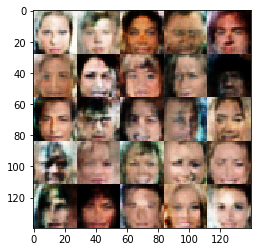

Epoch 1/1...   33.3% Discriminator Loss: 0.6472... Generator Loss: 1.5898
Epoch 1/1...   33.5% Discriminator Loss: 1.0767... Generator Loss: 2.1242
Epoch 1/1...   33.6% Discriminator Loss: 0.9653... Generator Loss: 0.9146
Epoch 1/1...   33.8% Discriminator Loss: 0.5300... Generator Loss: 3.5463
Epoch 1/1...   33.9% Discriminator Loss: 0.7072... Generator Loss: 1.4364
Epoch 1/1...   34.1% Discriminator Loss: 1.0241... Generator Loss: 0.8525
Epoch 1/1...   34.3% Discriminator Loss: 0.6706... Generator Loss: 3.0465
Epoch 1/1...   34.4% Discriminator Loss: 0.3560... Generator Loss: 4.3545
Epoch 1/1...   34.6% Discriminator Loss: 0.3717... Generator Loss: 3.6172
Epoch 1/1...   34.7% Discriminator Loss: 0.7530... Generator Loss: 1.3031


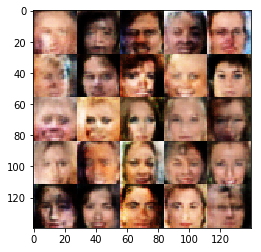

Epoch 1/1...   34.9% Discriminator Loss: 0.8931... Generator Loss: 1.0141
Epoch 1/1...   35.0% Discriminator Loss: 0.8391... Generator Loss: 1.1250
Epoch 1/1...   35.2% Discriminator Loss: 0.5444... Generator Loss: 2.0250
Epoch 1/1...   35.4% Discriminator Loss: 0.8310... Generator Loss: 1.0622
Epoch 1/1...   35.5% Discriminator Loss: 0.4561... Generator Loss: 2.7828
Epoch 1/1...   35.7% Discriminator Loss: 0.4413... Generator Loss: 2.6950
Epoch 1/1...   35.8% Discriminator Loss: 0.5149... Generator Loss: 2.9185
Epoch 1/1...   36.0% Discriminator Loss: 1.2104... Generator Loss: 0.6712
Epoch 1/1...   36.2% Discriminator Loss: 0.8318... Generator Loss: 1.5742
Epoch 1/1...   36.3% Discriminator Loss: 0.3591... Generator Loss: 4.7433


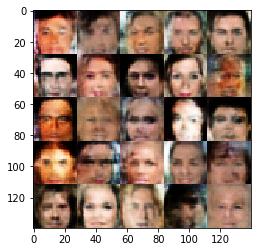

Epoch 1/1...   36.5% Discriminator Loss: 1.9526... Generator Loss: 0.2864
Epoch 1/1...   36.6% Discriminator Loss: 0.7124... Generator Loss: 1.8346
Epoch 1/1...   36.8% Discriminator Loss: 0.4494... Generator Loss: 2.7144
Epoch 1/1...   36.9% Discriminator Loss: 0.6207... Generator Loss: 1.7363
Epoch 1/1...   37.1% Discriminator Loss: 0.9697... Generator Loss: 1.4071
Epoch 1/1...   37.3% Discriminator Loss: 0.8885... Generator Loss: 1.3155
Epoch 1/1...   37.4% Discriminator Loss: 0.7540... Generator Loss: 3.5781
Epoch 1/1...   37.6% Discriminator Loss: 0.5114... Generator Loss: 2.3286
Epoch 1/1...   37.7% Discriminator Loss: 1.6742... Generator Loss: 0.3593
Epoch 1/1...   37.9% Discriminator Loss: 0.7585... Generator Loss: 5.9911


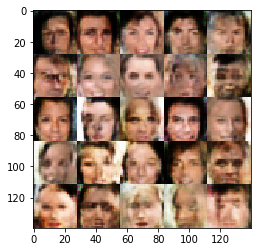

Epoch 1/1...   38.1% Discriminator Loss: 1.0104... Generator Loss: 0.8242
Epoch 1/1...   38.2% Discriminator Loss: 1.0293... Generator Loss: 1.7158
Epoch 1/1...   38.4% Discriminator Loss: 0.3996... Generator Loss: 3.3736
Epoch 1/1...   38.5% Discriminator Loss: 1.4348... Generator Loss: 0.5011
Epoch 1/1...   38.7% Discriminator Loss: 0.3830... Generator Loss: 3.5570
Epoch 1/1...   38.8% Discriminator Loss: 0.7100... Generator Loss: 2.8364
Epoch 1/1...   39.0% Discriminator Loss: 0.9517... Generator Loss: 1.9065
Epoch 1/1...   39.2% Discriminator Loss: 0.5308... Generator Loss: 3.0895
Epoch 1/1...   39.3% Discriminator Loss: 0.7665... Generator Loss: 1.1932
Epoch 1/1...   39.5% Discriminator Loss: 0.7002... Generator Loss: 1.5209


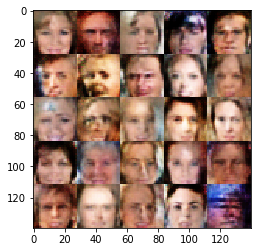

Epoch 1/1...   39.6% Discriminator Loss: 0.4243... Generator Loss: 2.8562
Epoch 1/1...   39.8% Discriminator Loss: 1.2152... Generator Loss: 0.6494
Epoch 1/1...   39.9% Discriminator Loss: 0.6069... Generator Loss: 1.5942
Epoch 1/1...   40.1% Discriminator Loss: 0.5770... Generator Loss: 1.9739
Epoch 1/1...   40.3% Discriminator Loss: 0.6004... Generator Loss: 1.7420
Epoch 1/1...   40.4% Discriminator Loss: 0.7421... Generator Loss: 1.2614
Epoch 1/1...   40.6% Discriminator Loss: 0.4758... Generator Loss: 4.4108
Epoch 1/1...   40.7% Discriminator Loss: 0.7141... Generator Loss: 1.3201
Epoch 1/1...   40.9% Discriminator Loss: 0.5474... Generator Loss: 2.4204
Epoch 1/1...   41.1% Discriminator Loss: 0.4461... Generator Loss: 3.5573


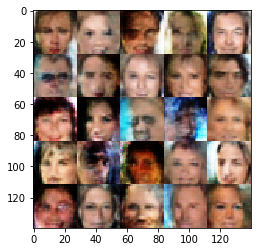

Epoch 1/1...   41.2% Discriminator Loss: 0.5066... Generator Loss: 2.3065
Epoch 1/1...   41.4% Discriminator Loss: 0.5772... Generator Loss: 2.2781
Epoch 1/1...   41.5% Discriminator Loss: 0.5039... Generator Loss: 2.2370
Epoch 1/1...   41.7% Discriminator Loss: 0.4249... Generator Loss: 4.0337
Epoch 1/1...   41.8% Discriminator Loss: 0.4320... Generator Loss: 2.8311
Epoch 1/1...   42.0% Discriminator Loss: 0.4928... Generator Loss: 2.1900
Epoch 1/1...   42.2% Discriminator Loss: 0.6763... Generator Loss: 1.4741
Epoch 1/1...   42.3% Discriminator Loss: 1.3623... Generator Loss: 0.5424
Epoch 1/1...   42.5% Discriminator Loss: 0.5615... Generator Loss: 1.7782
Epoch 1/1...   42.6% Discriminator Loss: 0.4006... Generator Loss: 3.6483


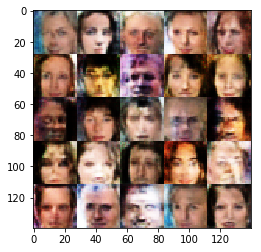

Epoch 1/1...   42.8% Discriminator Loss: 0.7359... Generator Loss: 1.3958
Epoch 1/1...   42.9% Discriminator Loss: 0.5442... Generator Loss: 2.0301
Epoch 1/1...   43.1% Discriminator Loss: 1.0363... Generator Loss: 6.5973
Epoch 1/1...   43.3% Discriminator Loss: 1.4384... Generator Loss: 0.4606
Epoch 1/1...   43.4% Discriminator Loss: 1.0687... Generator Loss: 0.8164
Epoch 1/1...   43.6% Discriminator Loss: 0.3968... Generator Loss: 3.5582
Epoch 1/1...   43.7% Discriminator Loss: 0.8325... Generator Loss: 1.0929
Epoch 1/1...   43.9% Discriminator Loss: 0.5729... Generator Loss: 2.3576
Epoch 1/1...   44.1% Discriminator Loss: 0.7669... Generator Loss: 1.2057
Epoch 1/1...   44.2% Discriminator Loss: 0.5062... Generator Loss: 2.5400


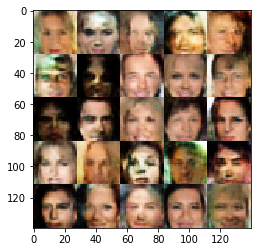

Epoch 1/1...   44.4% Discriminator Loss: 0.7731... Generator Loss: 1.2210
Epoch 1/1...   44.5% Discriminator Loss: 0.7220... Generator Loss: 1.6942
Epoch 1/1...   44.7% Discriminator Loss: 1.1427... Generator Loss: 0.6985
Epoch 1/1...   44.8% Discriminator Loss: 1.2552... Generator Loss: 0.6005
Epoch 1/1...   45.0% Discriminator Loss: 0.4524... Generator Loss: 2.5903
Epoch 1/1...   45.2% Discriminator Loss: 0.4984... Generator Loss: 2.1109
Epoch 1/1...   45.3% Discriminator Loss: 0.8627... Generator Loss: 1.5915
Epoch 1/1...   45.5% Discriminator Loss: 0.9934... Generator Loss: 0.9382
Epoch 1/1...   45.6% Discriminator Loss: 0.6061... Generator Loss: 2.7936
Epoch 1/1...   45.8% Discriminator Loss: 0.6899... Generator Loss: 1.3925


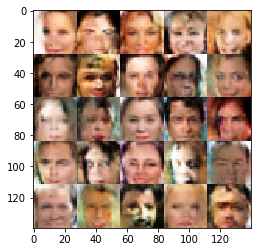

Epoch 1/1...   45.9% Discriminator Loss: 0.9119... Generator Loss: 0.9551
Epoch 1/1...   46.1% Discriminator Loss: 0.8680... Generator Loss: 1.7547
Epoch 1/1...   46.3% Discriminator Loss: 0.5069... Generator Loss: 2.2972
Epoch 1/1...   46.4% Discriminator Loss: 0.7126... Generator Loss: 1.3572
Epoch 1/1...   46.6% Discriminator Loss: 0.3961... Generator Loss: 3.4816
Epoch 1/1...   46.7% Discriminator Loss: 1.5174... Generator Loss: 0.4838
Epoch 1/1...   46.9% Discriminator Loss: 0.6109... Generator Loss: 1.7409
Epoch 1/1...   47.1% Discriminator Loss: 0.5032... Generator Loss: 3.7439
Epoch 1/1...   47.2% Discriminator Loss: 0.7722... Generator Loss: 1.2207
Epoch 1/1...   47.4% Discriminator Loss: 0.6045... Generator Loss: 1.8061


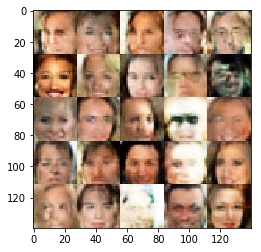

Epoch 1/1...   47.5% Discriminator Loss: 0.4407... Generator Loss: 4.0639
Epoch 1/1...   47.7% Discriminator Loss: 1.0097... Generator Loss: 0.8225
Epoch 1/1...   47.8% Discriminator Loss: 1.6637... Generator Loss: 0.3942
Epoch 1/1...   48.0% Discriminator Loss: 0.4611... Generator Loss: 2.8960
Epoch 1/1...   48.2% Discriminator Loss: 0.6015... Generator Loss: 1.7498
Epoch 1/1...   48.3% Discriminator Loss: 1.0061... Generator Loss: 0.8168
Epoch 1/1...   48.5% Discriminator Loss: 1.3570... Generator Loss: 0.5590
Epoch 1/1...   48.6% Discriminator Loss: 0.6015... Generator Loss: 1.7918
Epoch 1/1...   48.8% Discriminator Loss: 1.4959... Generator Loss: 0.4280
Epoch 1/1...   48.9% Discriminator Loss: 0.4569... Generator Loss: 2.8182


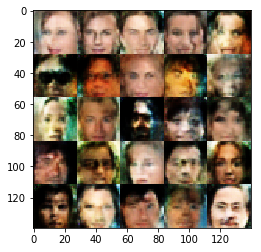

Epoch 1/1...   49.1% Discriminator Loss: 1.0178... Generator Loss: 0.9071
Epoch 1/1...   49.3% Discriminator Loss: 0.4496... Generator Loss: 3.6022
Epoch 1/1...   49.4% Discriminator Loss: 1.4869... Generator Loss: 0.4675
Epoch 1/1...   49.6% Discriminator Loss: 0.6078... Generator Loss: 1.8051
Epoch 1/1...   49.7% Discriminator Loss: 0.5181... Generator Loss: 2.0088
Epoch 1/1...   49.9% Discriminator Loss: 0.8647... Generator Loss: 0.9753
Epoch 1/1...   50.1% Discriminator Loss: 0.7104... Generator Loss: 1.6953
Epoch 1/1...   50.2% Discriminator Loss: 0.4815... Generator Loss: 2.3143
Epoch 1/1...   50.4% Discriminator Loss: 0.4780... Generator Loss: 2.5439
Epoch 1/1...   50.5% Discriminator Loss: 0.9202... Generator Loss: 1.0013


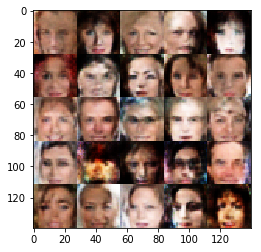

Epoch 1/1...   50.7% Discriminator Loss: 1.0830... Generator Loss: 0.7753
Epoch 1/1...   50.8% Discriminator Loss: 0.8540... Generator Loss: 1.1031
Epoch 1/1...   51.0% Discriminator Loss: 0.9535... Generator Loss: 0.9658
Epoch 1/1...   51.2% Discriminator Loss: 0.9736... Generator Loss: 0.9000
Epoch 1/1...   51.3% Discriminator Loss: 1.0423... Generator Loss: 0.8461
Epoch 1/1...   51.5% Discriminator Loss: 0.6607... Generator Loss: 1.6800
Epoch 1/1...   51.6% Discriminator Loss: 0.4980... Generator Loss: 3.2353
Epoch 1/1...   51.8% Discriminator Loss: 1.1919... Generator Loss: 0.6584
Epoch 1/1...   52.0% Discriminator Loss: 1.0680... Generator Loss: 0.8331
Epoch 1/1...   52.1% Discriminator Loss: 0.8340... Generator Loss: 1.5571


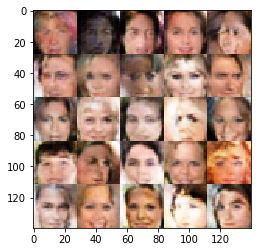

Epoch 1/1...   52.3% Discriminator Loss: 0.7171... Generator Loss: 1.4233
Epoch 1/1...   52.4% Discriminator Loss: 0.7929... Generator Loss: 1.8846
Epoch 1/1...   52.6% Discriminator Loss: 0.5200... Generator Loss: 2.1595
Epoch 1/1...   52.7% Discriminator Loss: 0.8403... Generator Loss: 1.1621
Epoch 1/1...   52.9% Discriminator Loss: 0.9211... Generator Loss: 1.4669
Epoch 1/1...   53.1% Discriminator Loss: 0.5983... Generator Loss: 3.9825
Epoch 1/1...   53.2% Discriminator Loss: 0.4512... Generator Loss: 2.8870
Epoch 1/1...   53.4% Discriminator Loss: 0.5791... Generator Loss: 1.8780
Epoch 1/1...   53.5% Discriminator Loss: 0.9099... Generator Loss: 1.1779
Epoch 1/1...   53.7% Discriminator Loss: 0.7851... Generator Loss: 1.4308


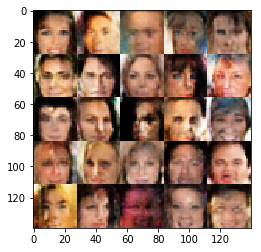

Epoch 1/1...   53.8% Discriminator Loss: 0.8671... Generator Loss: 1.0641
Epoch 1/1...   54.0% Discriminator Loss: 0.5250... Generator Loss: 3.3817
Epoch 1/1...   54.2% Discriminator Loss: 1.1254... Generator Loss: 0.6580
Epoch 1/1...   54.3% Discriminator Loss: 0.9724... Generator Loss: 0.8725
Epoch 1/1...   54.5% Discriminator Loss: 0.9056... Generator Loss: 0.9550
Epoch 1/1...   54.6% Discriminator Loss: 0.5717... Generator Loss: 1.8414
Epoch 1/1...   54.8% Discriminator Loss: 0.6391... Generator Loss: 1.7863
Epoch 1/1...   55.0% Discriminator Loss: 0.4008... Generator Loss: 4.9197
Epoch 1/1...   55.1% Discriminator Loss: 0.8160... Generator Loss: 1.0929
Epoch 1/1...   55.3% Discriminator Loss: 1.9037... Generator Loss: 0.3121


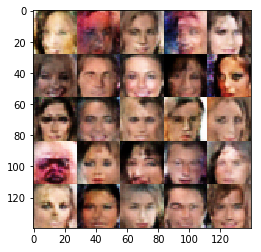

Epoch 1/1...   55.4% Discriminator Loss: 0.6396... Generator Loss: 1.5248
Epoch 1/1...   55.6% Discriminator Loss: 0.9418... Generator Loss: 0.8984
Epoch 1/1...   55.7% Discriminator Loss: 0.7643... Generator Loss: 1.5908
Epoch 1/1...   55.9% Discriminator Loss: 0.5027... Generator Loss: 2.3072
Epoch 1/1...   56.1% Discriminator Loss: 0.5950... Generator Loss: 2.6841
Epoch 1/1...   56.2% Discriminator Loss: 0.6639... Generator Loss: 1.5981
Epoch 1/1...   56.4% Discriminator Loss: 0.6864... Generator Loss: 1.8603
Epoch 1/1...   56.5% Discriminator Loss: 0.6174... Generator Loss: 4.1860
Epoch 1/1...   56.7% Discriminator Loss: 0.7970... Generator Loss: 1.1952
Epoch 1/1...   56.8% Discriminator Loss: 0.9492... Generator Loss: 1.2565


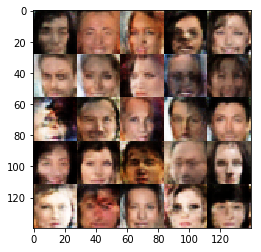

Epoch 1/1...   57.0% Discriminator Loss: 1.4331... Generator Loss: 0.5114
Epoch 1/1...   57.2% Discriminator Loss: 1.1596... Generator Loss: 0.6855
Epoch 1/1...   57.3% Discriminator Loss: 0.8986... Generator Loss: 0.9190
Epoch 1/1...   57.5% Discriminator Loss: 0.8615... Generator Loss: 1.0802
Epoch 1/1...   57.6% Discriminator Loss: 0.5635... Generator Loss: 1.9697
Epoch 1/1...   57.8% Discriminator Loss: 0.9172... Generator Loss: 1.0954
Epoch 1/1...   58.0% Discriminator Loss: 1.4522... Generator Loss: 0.5114
Epoch 1/1...   58.1% Discriminator Loss: 2.3240... Generator Loss: 3.3693
Epoch 1/1...   58.3% Discriminator Loss: 1.1878... Generator Loss: 0.6570
Epoch 1/1...   58.4% Discriminator Loss: 1.2781... Generator Loss: 0.5783


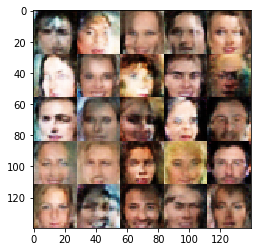

Epoch 1/1...   58.6% Discriminator Loss: 0.7384... Generator Loss: 1.2989
Epoch 1/1...   58.7% Discriminator Loss: 0.5638... Generator Loss: 2.3541
Epoch 1/1...   58.9% Discriminator Loss: 0.7991... Generator Loss: 1.2598
Epoch 1/1...   59.1% Discriminator Loss: 0.4986... Generator Loss: 3.6682
Epoch 1/1...   59.2% Discriminator Loss: 0.8502... Generator Loss: 1.5119
Epoch 1/1...   59.4% Discriminator Loss: 0.5113... Generator Loss: 2.7641
Epoch 1/1...   59.5% Discriminator Loss: 0.8015... Generator Loss: 1.4073
Epoch 1/1...   59.7% Discriminator Loss: 1.0459... Generator Loss: 1.6728
Epoch 1/1...   59.8% Discriminator Loss: 0.7050... Generator Loss: 1.3289
Epoch 1/1...   60.0% Discriminator Loss: 0.7482... Generator Loss: 1.3275


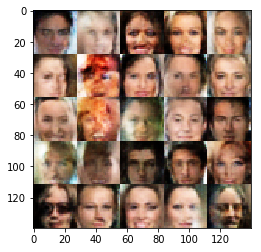

Epoch 1/1...   60.2% Discriminator Loss: 0.8482... Generator Loss: 1.0892
Epoch 1/1...   60.3% Discriminator Loss: 0.3888... Generator Loss: 4.6177
Epoch 1/1...   60.5% Discriminator Loss: 0.6557... Generator Loss: 1.9564
Epoch 1/1...   60.6% Discriminator Loss: 0.9373... Generator Loss: 1.0085
Epoch 1/1...   60.8% Discriminator Loss: 0.3811... Generator Loss: 3.6519
Epoch 1/1...   61.0% Discriminator Loss: 0.5870... Generator Loss: 1.7581
Epoch 1/1...   61.1% Discriminator Loss: 1.0009... Generator Loss: 0.8839
Epoch 1/1...   61.3% Discriminator Loss: 0.4422... Generator Loss: 2.8049
Epoch 1/1...   61.4% Discriminator Loss: 1.3006... Generator Loss: 0.5749
Epoch 1/1...   61.6% Discriminator Loss: 0.6456... Generator Loss: 1.5102


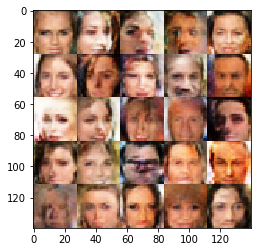

Epoch 1/1...   61.7% Discriminator Loss: 1.1010... Generator Loss: 0.7237
Epoch 1/1...   61.9% Discriminator Loss: 0.6951... Generator Loss: 1.3777
Epoch 1/1...   62.1% Discriminator Loss: 0.5429... Generator Loss: 1.8938
Epoch 1/1...   62.2% Discriminator Loss: 0.7534... Generator Loss: 1.8360
Epoch 1/1...   62.4% Discriminator Loss: 0.6831... Generator Loss: 1.7952
Epoch 1/1...   62.5% Discriminator Loss: 0.4511... Generator Loss: 2.6223
Epoch 1/1...   62.7% Discriminator Loss: 0.9946... Generator Loss: 0.8792
Epoch 1/1...   62.8% Discriminator Loss: 1.1139... Generator Loss: 0.6727
Epoch 1/1...   63.0% Discriminator Loss: 1.1237... Generator Loss: 0.7067
Epoch 1/1...   63.2% Discriminator Loss: 1.0319... Generator Loss: 0.8134


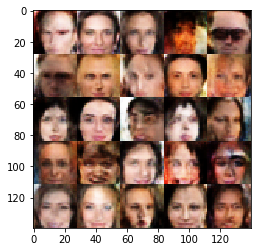

Epoch 1/1...   63.3% Discriminator Loss: 0.7500... Generator Loss: 1.6007
Epoch 1/1...   63.5% Discriminator Loss: 0.6121... Generator Loss: 6.3805
Epoch 1/1...   63.6% Discriminator Loss: 0.5821... Generator Loss: 1.6843
Epoch 1/1...   63.8% Discriminator Loss: 0.7740... Generator Loss: 1.1818
Epoch 1/1...   64.0% Discriminator Loss: 1.9906... Generator Loss: 0.2716
Epoch 1/1...   64.1% Discriminator Loss: 1.3443... Generator Loss: 0.5115
Epoch 1/1...   64.3% Discriminator Loss: 0.5475... Generator Loss: 2.0547
Epoch 1/1...   64.4% Discriminator Loss: 0.5376... Generator Loss: 2.5971
Epoch 1/1...   64.6% Discriminator Loss: 0.4623... Generator Loss: 2.7624
Epoch 1/1...   64.7% Discriminator Loss: 1.0277... Generator Loss: 0.8430


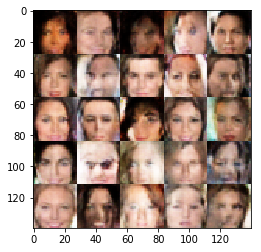

Epoch 1/1...   64.9% Discriminator Loss: 0.8623... Generator Loss: 1.0690
Epoch 1/1...   65.1% Discriminator Loss: 0.8459... Generator Loss: 1.0649
Epoch 1/1...   65.2% Discriminator Loss: 0.3754... Generator Loss: 4.3835
Epoch 1/1...   65.4% Discriminator Loss: 1.0673... Generator Loss: 0.7850
Epoch 1/1...   65.5% Discriminator Loss: 0.4855... Generator Loss: 2.4434
Epoch 1/1...   65.7% Discriminator Loss: 0.6000... Generator Loss: 1.7948
Epoch 1/1...   65.9% Discriminator Loss: 0.9337... Generator Loss: 1.0042
Epoch 1/1...   66.0% Discriminator Loss: 1.2681... Generator Loss: 0.5790
Epoch 1/1...   66.2% Discriminator Loss: 0.6100... Generator Loss: 1.6867
Epoch 1/1...   66.3% Discriminator Loss: 0.7219... Generator Loss: 1.4216


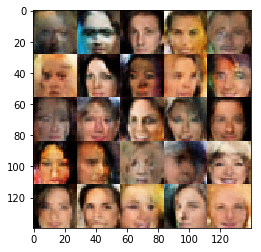

Epoch 1/1...   66.5% Discriminator Loss: 0.5508... Generator Loss: 1.9807
Epoch 1/1...   66.6% Discriminator Loss: 0.7559... Generator Loss: 1.2777
Epoch 1/1...   66.8% Discriminator Loss: 1.1588... Generator Loss: 2.4490
Epoch 1/1...   67.0% Discriminator Loss: 1.8672... Generator Loss: 0.3204
Epoch 1/1...   67.1% Discriminator Loss: 0.7772... Generator Loss: 1.2211
Epoch 1/1...   67.3% Discriminator Loss: 0.4187... Generator Loss: 4.6901
Epoch 1/1...   67.4% Discriminator Loss: 0.9020... Generator Loss: 1.0381
Epoch 1/1...   67.6% Discriminator Loss: 1.9014... Generator Loss: 0.3199
Epoch 1/1...   67.7% Discriminator Loss: 1.0321... Generator Loss: 2.7920
Epoch 1/1...   67.9% Discriminator Loss: 0.8335... Generator Loss: 1.0983


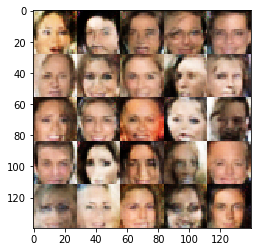

Epoch 1/1...   68.1% Discriminator Loss: 0.9899... Generator Loss: 0.8991
Epoch 1/1...   68.2% Discriminator Loss: 1.0759... Generator Loss: 0.7815
Epoch 1/1...   68.4% Discriminator Loss: 0.4802... Generator Loss: 2.2669
Epoch 1/1...   68.5% Discriminator Loss: 0.7046... Generator Loss: 1.4098
Epoch 1/1...   68.7% Discriminator Loss: 0.6482... Generator Loss: 2.2870
Epoch 1/1...   68.9% Discriminator Loss: 0.6809... Generator Loss: 1.5108
Epoch 1/1...   69.0% Discriminator Loss: 1.5704... Generator Loss: 0.3796
Epoch 1/1...   69.2% Discriminator Loss: 1.0158... Generator Loss: 1.7735
Epoch 1/1...   69.3% Discriminator Loss: 0.8795... Generator Loss: 2.5871
Epoch 1/1...   69.5% Discriminator Loss: 0.8227... Generator Loss: 1.1358


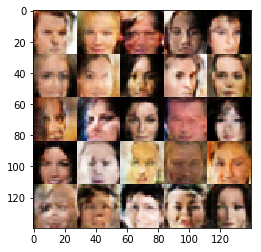

Epoch 1/1...   69.6% Discriminator Loss: 0.9620... Generator Loss: 0.9031
Epoch 1/1...   69.8% Discriminator Loss: 0.5994... Generator Loss: 2.5547
Epoch 1/1...   70.0% Discriminator Loss: 0.8861... Generator Loss: 0.9992
Epoch 1/1...   70.1% Discriminator Loss: 0.7226... Generator Loss: 1.3536
Epoch 1/1...   70.3% Discriminator Loss: 0.4901... Generator Loss: 2.7463
Epoch 1/1...   70.4% Discriminator Loss: 1.4924... Generator Loss: 0.4509
Epoch 1/1...   70.6% Discriminator Loss: 0.6825... Generator Loss: 1.4653
Epoch 1/1...   70.7% Discriminator Loss: 1.1173... Generator Loss: 0.7776
Epoch 1/1...   70.9% Discriminator Loss: 1.1246... Generator Loss: 2.0841
Epoch 1/1...   71.1% Discriminator Loss: 0.5646... Generator Loss: 2.4730


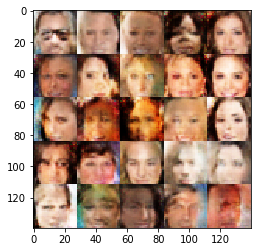

Epoch 1/1...   71.2% Discriminator Loss: 0.6406... Generator Loss: 1.5309
Epoch 1/1...   71.4% Discriminator Loss: 0.8644... Generator Loss: 1.0972
Epoch 1/1...   71.5% Discriminator Loss: 1.2379... Generator Loss: 0.6270
Epoch 1/1...   71.7% Discriminator Loss: 0.7145... Generator Loss: 2.4643
Epoch 1/1...   71.9% Discriminator Loss: 0.6860... Generator Loss: 1.9369
Epoch 1/1...   72.0% Discriminator Loss: 0.4100... Generator Loss: 3.0303
Epoch 1/1...   72.2% Discriminator Loss: 0.5194... Generator Loss: 3.6554
Epoch 1/1...   72.3% Discriminator Loss: 0.6247... Generator Loss: 2.4516
Epoch 1/1...   72.5% Discriminator Loss: 0.7706... Generator Loss: 1.3080
Epoch 1/1...   72.6% Discriminator Loss: 1.4700... Generator Loss: 0.4690


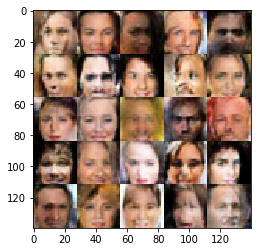

Epoch 1/1...   72.8% Discriminator Loss: 1.1354... Generator Loss: 0.7788
Epoch 1/1...   73.0% Discriminator Loss: 1.4395... Generator Loss: 0.4570
Epoch 1/1...   73.1% Discriminator Loss: 0.6466... Generator Loss: 2.0732
Epoch 1/1...   73.3% Discriminator Loss: 1.0201... Generator Loss: 0.8362
Epoch 1/1...   73.4% Discriminator Loss: 0.4000... Generator Loss: 3.2751
Epoch 1/1...   73.6% Discriminator Loss: 0.8073... Generator Loss: 1.2030
Epoch 1/1...   73.7% Discriminator Loss: 1.2814... Generator Loss: 3.1577
Epoch 1/1...   73.9% Discriminator Loss: 1.5083... Generator Loss: 0.4808
Epoch 1/1...   74.1% Discriminator Loss: 0.4563... Generator Loss: 2.8877
Epoch 1/1...   74.2% Discriminator Loss: 1.4466... Generator Loss: 0.4590


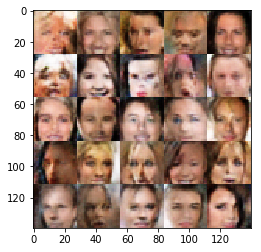

Epoch 1/1...   74.4% Discriminator Loss: 1.1353... Generator Loss: 0.7236
Epoch 1/1...   74.5% Discriminator Loss: 0.4982... Generator Loss: 2.3118
Epoch 1/1...   74.7% Discriminator Loss: 0.5665... Generator Loss: 1.8289
Epoch 1/1...   74.9% Discriminator Loss: 0.5045... Generator Loss: 4.4539
Epoch 1/1...   75.0% Discriminator Loss: 0.5978... Generator Loss: 2.3017
Epoch 1/1...   75.2% Discriminator Loss: 0.6172... Generator Loss: 1.6208
Epoch 1/1...   75.3% Discriminator Loss: 0.8240... Generator Loss: 1.3327
Epoch 1/1...   75.5% Discriminator Loss: 1.4418... Generator Loss: 0.4480
Epoch 1/1...   75.6% Discriminator Loss: 1.1826... Generator Loss: 3.5027
Epoch 1/1...   75.8% Discriminator Loss: 0.5370... Generator Loss: 3.1109


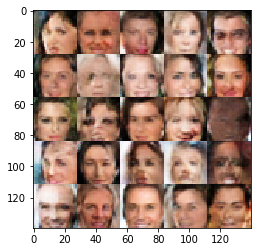

Epoch 1/1...   76.0% Discriminator Loss: 0.9294... Generator Loss: 0.9225
Epoch 1/1...   76.1% Discriminator Loss: 1.4892... Generator Loss: 2.2814
Epoch 1/1...   76.3% Discriminator Loss: 0.4730... Generator Loss: 2.5292
Epoch 1/1...   76.4% Discriminator Loss: 0.7827... Generator Loss: 1.1336
Epoch 1/1...   76.6% Discriminator Loss: 1.1076... Generator Loss: 0.7007
Epoch 1/1...   76.7% Discriminator Loss: 1.2672... Generator Loss: 0.5671
Epoch 1/1...   76.9% Discriminator Loss: 0.5169... Generator Loss: 2.5497
Epoch 1/1...   77.1% Discriminator Loss: 0.9215... Generator Loss: 1.0630
Epoch 1/1...   77.2% Discriminator Loss: 0.6713... Generator Loss: 1.5139
Epoch 1/1...   77.4% Discriminator Loss: 0.9922... Generator Loss: 0.8775


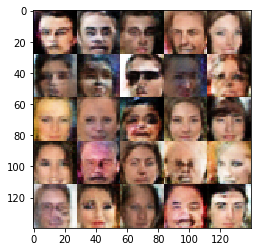

Epoch 1/1...   77.5% Discriminator Loss: 0.5661... Generator Loss: 4.7203
Epoch 1/1...   77.7% Discriminator Loss: 1.2904... Generator Loss: 0.7961
Epoch 1/1...   77.9% Discriminator Loss: 0.5961... Generator Loss: 1.7715
Epoch 1/1...   78.0% Discriminator Loss: 0.5629... Generator Loss: 2.3205
Epoch 1/1...   78.2% Discriminator Loss: 0.6345... Generator Loss: 1.5748
Epoch 1/1...   78.3% Discriminator Loss: 1.2478... Generator Loss: 2.2690
Epoch 1/1...   78.5% Discriminator Loss: 0.4754... Generator Loss: 2.6593
Epoch 1/1...   78.6% Discriminator Loss: 0.6618... Generator Loss: 2.7586
Epoch 1/1...   78.8% Discriminator Loss: 0.8496... Generator Loss: 1.0565
Epoch 1/1...   79.0% Discriminator Loss: 0.7438... Generator Loss: 1.2374


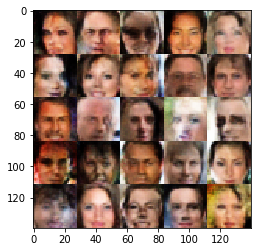

Epoch 1/1...   79.1% Discriminator Loss: 1.1565... Generator Loss: 0.7833
Epoch 1/1...   79.3% Discriminator Loss: 0.6251... Generator Loss: 1.5830
Epoch 1/1...   79.4% Discriminator Loss: 0.3823... Generator Loss: 3.6352
Epoch 1/1...   79.6% Discriminator Loss: 0.7524... Generator Loss: 1.7103
Epoch 1/1...   79.8% Discriminator Loss: 0.7282... Generator Loss: 2.4076
Epoch 1/1...   79.9% Discriminator Loss: 0.6314... Generator Loss: 1.5134
Epoch 1/1...   80.1% Discriminator Loss: 1.0978... Generator Loss: 0.7503
Epoch 1/1...   80.2% Discriminator Loss: 0.7171... Generator Loss: 1.2741
Epoch 1/1...   80.4% Discriminator Loss: 0.5360... Generator Loss: 1.9357
Epoch 1/1...   80.5% Discriminator Loss: 1.1364... Generator Loss: 0.7236


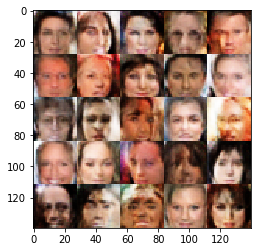

Epoch 1/1...   80.7% Discriminator Loss: 1.6381... Generator Loss: 0.4047
Epoch 1/1...   80.9% Discriminator Loss: 1.0020... Generator Loss: 2.1276
Epoch 1/1...   81.0% Discriminator Loss: 0.4675... Generator Loss: 2.8295
Epoch 1/1...   81.2% Discriminator Loss: 1.0127... Generator Loss: 0.9308
Epoch 1/1...   81.3% Discriminator Loss: 1.6965... Generator Loss: 0.3855
Epoch 1/1...   81.5% Discriminator Loss: 0.4743... Generator Loss: 2.4214
Epoch 1/1...   81.6% Discriminator Loss: 1.3048... Generator Loss: 0.5606
Epoch 1/1...   81.8% Discriminator Loss: 0.8278... Generator Loss: 2.2605
Epoch 1/1...   82.0% Discriminator Loss: 1.0913... Generator Loss: 0.7233
Epoch 1/1...   82.1% Discriminator Loss: 0.8363... Generator Loss: 1.1022


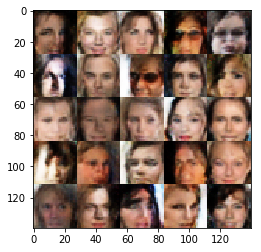

Epoch 1/1...   82.3% Discriminator Loss: 0.4519... Generator Loss: 2.5582
Epoch 1/1...   82.4% Discriminator Loss: 0.7384... Generator Loss: 1.4264
Epoch 1/1...   82.6% Discriminator Loss: 0.6433... Generator Loss: 1.5514
Epoch 1/1...   82.8% Discriminator Loss: 0.6225... Generator Loss: 1.5734
Epoch 1/1...   82.9% Discriminator Loss: 1.1562... Generator Loss: 0.6456
Epoch 1/1...   83.1% Discriminator Loss: 0.7081... Generator Loss: 4.0343
Epoch 1/1...   83.2% Discriminator Loss: 0.9875... Generator Loss: 0.8604
Epoch 1/1...   83.4% Discriminator Loss: 0.8744... Generator Loss: 1.3179
Epoch 1/1...   83.5% Discriminator Loss: 0.9321... Generator Loss: 0.9848
Epoch 1/1...   83.7% Discriminator Loss: 0.9468... Generator Loss: 0.9464


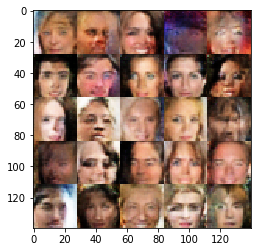

Epoch 1/1...   83.9% Discriminator Loss: 0.9387... Generator Loss: 0.9632
Epoch 1/1...   84.0% Discriminator Loss: 0.6491... Generator Loss: 1.8072
Epoch 1/1...   84.2% Discriminator Loss: 0.9078... Generator Loss: 0.9443
Epoch 1/1...   84.3% Discriminator Loss: 0.6585... Generator Loss: 1.6812
Epoch 1/1...   84.5% Discriminator Loss: 0.9496... Generator Loss: 0.9534
Epoch 1/1...   84.6% Discriminator Loss: 0.6079... Generator Loss: 2.4952
Epoch 1/1...   84.8% Discriminator Loss: 1.1374... Generator Loss: 0.7168
Epoch 1/1...   85.0% Discriminator Loss: 1.1103... Generator Loss: 0.7517
Epoch 1/1...   85.1% Discriminator Loss: 0.8586... Generator Loss: 1.7025
Epoch 1/1...   85.3% Discriminator Loss: 1.1157... Generator Loss: 1.2157


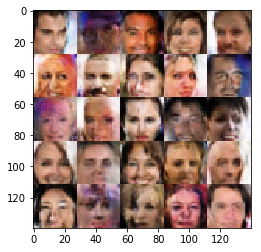

Epoch 1/1...   85.4% Discriminator Loss: 1.3996... Generator Loss: 0.4739
Epoch 1/1...   85.6% Discriminator Loss: 1.2393... Generator Loss: 0.6326
Epoch 1/1...   85.8% Discriminator Loss: 0.8307... Generator Loss: 1.2157
Epoch 1/1...   85.9% Discriminator Loss: 0.5078... Generator Loss: 2.3601
Epoch 1/1...   86.1% Discriminator Loss: 0.7439... Generator Loss: 1.3920
Epoch 1/1...   86.2% Discriminator Loss: 0.7860... Generator Loss: 1.8437
Epoch 1/1...   86.4% Discriminator Loss: 1.1257... Generator Loss: 1.5727
Epoch 1/1...   86.5% Discriminator Loss: 0.6660... Generator Loss: 3.5865
Epoch 1/1...   86.7% Discriminator Loss: 0.4229... Generator Loss: 3.4264
Epoch 1/1...   86.9% Discriminator Loss: 0.9816... Generator Loss: 0.8339


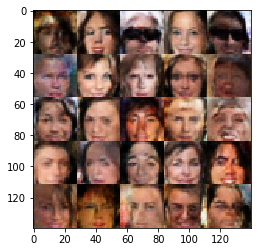

Epoch 1/1...   87.0% Discriminator Loss: 1.4457... Generator Loss: 0.5146
Epoch 1/1...   87.2% Discriminator Loss: 0.9540... Generator Loss: 0.8777
Epoch 1/1...   87.3% Discriminator Loss: 1.1853... Generator Loss: 1.3718
Epoch 1/1...   87.5% Discriminator Loss: 0.4825... Generator Loss: 2.6537
Epoch 1/1...   87.6% Discriminator Loss: 1.3013... Generator Loss: 0.6066
Epoch 1/1...   87.8% Discriminator Loss: 0.9746... Generator Loss: 0.9412
Epoch 1/1...   88.0% Discriminator Loss: 0.7623... Generator Loss: 1.2071
Epoch 1/1...   88.1% Discriminator Loss: 1.2845... Generator Loss: 0.5789
Epoch 1/1...   88.3% Discriminator Loss: 0.5763... Generator Loss: 2.3917
Epoch 1/1...   88.4% Discriminator Loss: 0.9262... Generator Loss: 0.9602


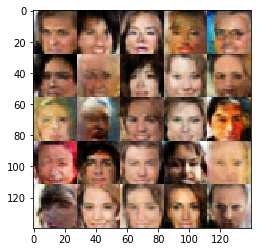

Epoch 1/1...   88.6% Discriminator Loss: 0.8125... Generator Loss: 1.2480
Epoch 1/1...   88.8% Discriminator Loss: 0.9009... Generator Loss: 1.1454
Epoch 1/1...   88.9% Discriminator Loss: 1.3714... Generator Loss: 0.4781
Epoch 1/1...   89.1% Discriminator Loss: 0.4144... Generator Loss: 3.8578
Epoch 1/1...   89.2% Discriminator Loss: 0.9734... Generator Loss: 2.6187
Epoch 1/1...   89.4% Discriminator Loss: 0.6967... Generator Loss: 1.3848
Epoch 1/1...   89.5% Discriminator Loss: 2.0703... Generator Loss: 2.3104
Epoch 1/1...   89.7% Discriminator Loss: 0.7393... Generator Loss: 1.3642
Epoch 1/1...   89.9% Discriminator Loss: 0.7526... Generator Loss: 1.2452
Epoch 1/1...   90.0% Discriminator Loss: 0.6891... Generator Loss: 1.4167


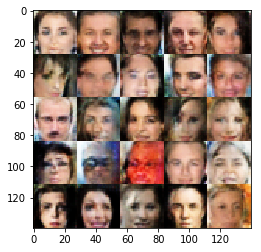

Epoch 1/1...   90.2% Discriminator Loss: 0.8905... Generator Loss: 1.4916
Epoch 1/1...   90.3% Discriminator Loss: 0.9040... Generator Loss: 0.9863
Epoch 1/1...   90.5% Discriminator Loss: 0.5839... Generator Loss: 1.9151
Epoch 1/1...   90.6% Discriminator Loss: 1.0114... Generator Loss: 1.7406
Epoch 1/1...   90.8% Discriminator Loss: 1.1049... Generator Loss: 0.7552
Epoch 1/1...   91.0% Discriminator Loss: 0.7414... Generator Loss: 1.6207
Epoch 1/1...   91.1% Discriminator Loss: 1.0241... Generator Loss: 1.4628
Epoch 1/1...   91.3% Discriminator Loss: 0.4575... Generator Loss: 3.5478
Epoch 1/1...   91.4% Discriminator Loss: 0.9690... Generator Loss: 0.8849
Epoch 1/1...   91.6% Discriminator Loss: 1.1116... Generator Loss: 0.7180


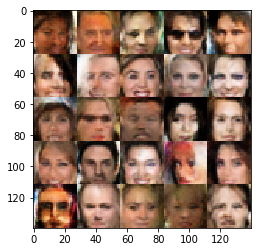

Epoch 1/1...   91.8% Discriminator Loss: 0.8773... Generator Loss: 1.4038
Epoch 1/1...   91.9% Discriminator Loss: 0.6985... Generator Loss: 1.9464
Epoch 1/1...   92.1% Discriminator Loss: 0.5864... Generator Loss: 1.8334
Epoch 1/1...   92.2% Discriminator Loss: 1.0641... Generator Loss: 2.0844
Epoch 1/1...   92.4% Discriminator Loss: 1.2931... Generator Loss: 0.6347
Epoch 1/1...   92.5% Discriminator Loss: 1.3470... Generator Loss: 0.5225
Epoch 1/1...   92.7% Discriminator Loss: 0.7532... Generator Loss: 2.1569
Epoch 1/1...   92.9% Discriminator Loss: 0.7044... Generator Loss: 1.4347
Epoch 1/1...   93.0% Discriminator Loss: 1.5460... Generator Loss: 0.4045
Epoch 1/1...   93.2% Discriminator Loss: 0.6547... Generator Loss: 1.6159


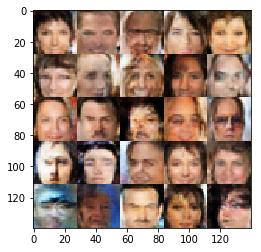

Epoch 1/1...   93.3% Discriminator Loss: 0.6658... Generator Loss: 1.4896
Epoch 1/1...   93.5% Discriminator Loss: 0.8430... Generator Loss: 1.0128
Epoch 1/1...   93.7% Discriminator Loss: 1.0997... Generator Loss: 0.7402
Epoch 1/1...   93.8% Discriminator Loss: 0.7912... Generator Loss: 1.1257
Epoch 1/1...   94.0% Discriminator Loss: 1.0543... Generator Loss: 1.1109
Epoch 1/1...   94.1% Discriminator Loss: 1.0548... Generator Loss: 0.7727
Epoch 1/1...   94.3% Discriminator Loss: 0.7124... Generator Loss: 1.3657
Epoch 1/1...   94.4% Discriminator Loss: 1.6482... Generator Loss: 0.3682
Epoch 1/1...   94.6% Discriminator Loss: 0.5506... Generator Loss: 3.1194
Epoch 1/1...   94.8% Discriminator Loss: 1.0534... Generator Loss: 0.9394


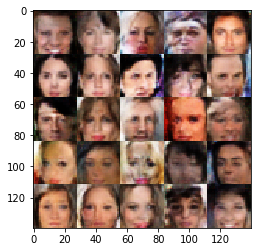

Epoch 1/1...   94.9% Discriminator Loss: 1.1484... Generator Loss: 1.5785
Epoch 1/1...   95.1% Discriminator Loss: 1.8316... Generator Loss: 0.3045
Epoch 1/1...   95.2% Discriminator Loss: 1.6599... Generator Loss: 0.3876
Epoch 1/1...   95.4% Discriminator Loss: 0.6806... Generator Loss: 1.7155
Epoch 1/1...   95.5% Discriminator Loss: 0.7147... Generator Loss: 1.5329
Epoch 1/1...   95.7% Discriminator Loss: 0.4730... Generator Loss: 2.5840
Epoch 1/1...   95.9% Discriminator Loss: 0.7285... Generator Loss: 1.3144
Epoch 1/1...   96.0% Discriminator Loss: 0.9017... Generator Loss: 0.9971
Epoch 1/1...   96.2% Discriminator Loss: 0.6134... Generator Loss: 2.0768
Epoch 1/1...   96.3% Discriminator Loss: 0.8872... Generator Loss: 0.9542


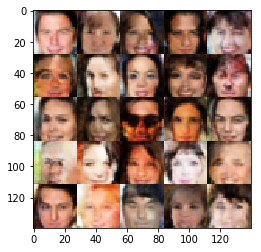

Epoch 1/1...   96.5% Discriminator Loss: 0.9800... Generator Loss: 0.8310
Epoch 1/1...   96.7% Discriminator Loss: 0.6296... Generator Loss: 1.9626
Epoch 1/1...   96.8% Discriminator Loss: 0.7953... Generator Loss: 1.2054
Epoch 1/1...   97.0% Discriminator Loss: 1.2137... Generator Loss: 0.7603
Epoch 1/1...   97.1% Discriminator Loss: 0.6288... Generator Loss: 1.6899
Epoch 1/1...   97.3% Discriminator Loss: 0.7770... Generator Loss: 1.3825
Epoch 1/1...   97.4% Discriminator Loss: 1.0373... Generator Loss: 0.8002
Epoch 1/1...   97.6% Discriminator Loss: 0.6234... Generator Loss: 1.7861
Epoch 1/1...   97.8% Discriminator Loss: 1.2294... Generator Loss: 0.6353
Epoch 1/1...   97.9% Discriminator Loss: 0.3822... Generator Loss: 3.4775


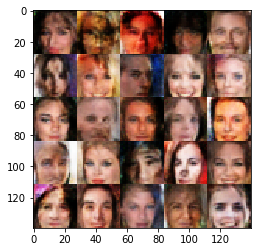

Epoch 1/1...   98.1% Discriminator Loss: 1.0532... Generator Loss: 0.7617
Epoch 1/1...   98.2% Discriminator Loss: 0.9059... Generator Loss: 1.0212
Epoch 1/1...   98.4% Discriminator Loss: 1.9265... Generator Loss: 0.2735
Epoch 1/1...   98.5% Discriminator Loss: 0.9634... Generator Loss: 0.8589
Epoch 1/1...   98.7% Discriminator Loss: 1.0622... Generator Loss: 0.7721
Epoch 1/1...   98.9% Discriminator Loss: 0.6014... Generator Loss: 2.6566
Epoch 1/1...   99.0% Discriminator Loss: 1.0547... Generator Loss: 1.0396
Epoch 1/1...   99.2% Discriminator Loss: 0.6101... Generator Loss: 1.8273
Epoch 1/1...   99.3% Discriminator Loss: 0.4238... Generator Loss: 3.2461
Epoch 1/1...   99.5% Discriminator Loss: 1.4199... Generator Loss: 0.4637


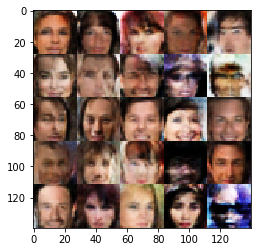

Epoch 1/1...   99.7% Discriminator Loss: 1.0922... Generator Loss: 0.7212
Epoch 1/1...   99.8% Discriminator Loss: 0.9998... Generator Loss: 0.8375
Epoch 1/1...  100.0% Discriminator Loss: 1.9103... Generator Loss: 0.2919


In [134]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.